In [30]:
import keras
import matplotlib.pyplot as plt 
import os
from PIL import Image
import numpy as np
from multiprocessing import Process, Manager


In [2]:

folders =['datasets/pristine', 'datasets/fake']
valid_images= ['.jpg', '.jpeg', '.png']

forged =[]
pristine = [] 
mask = [] 
y = []

for folder in folders:
  path = folder + '/'
  
  for f in os.listdir(path):
    
    ext = os.path.splitext(f)[1]
    
    if ext.lower() not in valid_images:
      continue 
      
    img_path = path + f

    if 'mask' in img_path[-10:]: 
      continue 
      
    
    im = np.array(Image.open(img_path))
    
    # those are the images with plain patches (discarded)
    if len(im.shape) < 3:
      continue 
    
    # print(f)

    
    if folder == 'datasets/fake':
      forged.append(im.reshape(im.shape[0], im.shape[1], im.shape[2]))
    
      name, ext = f.split('.')
      img_path = path + name + '.mask.' + ext
      
      im = np.array(Image.open(img_path).convert('L'))

      mask.append(im)
    else:
      pristine.append(im.reshape(im.shape[0], im.shape[1], im.shape[2]))
                        
    if folder == 'datasets/fake':
      y.append(1)
    elif folder == 'datasets/pristine':
      y.append(0)
      

y = np.array(y).reshape(-1, 1)

/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/PIL/Image.py:966: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [3]:
# binarize the masks 
import cv2
binaries = []
for grayscale in mask:
  blur = cv2.GaussianBlur(grayscale, (5,5), 0)
  ret, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  binaries.append(th)

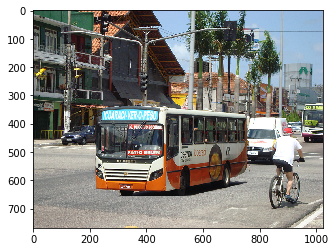

In [4]:
plt.imshow(forged[3])

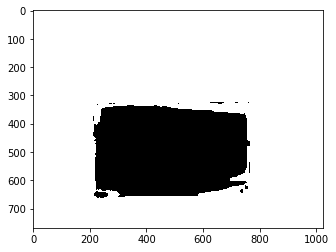

In [5]:
plt.imshow(binaries[3], cmap = 'gray')

In [6]:
len(forged), len(binaries), len(pristine)

(450, 450, 1025)

In [7]:
x_train_fake, x_test_fake = forged[:440], forged[440:]
x_train_fake_mask, x_test_fake_mask = binaries[:440], binaries[440:]

x_train_pristine, x_test_pristine = pristine[:1015], pristine[1015:]

len(x_train_fake), len(x_test_fake), len(x_train_fake_mask), len(x_test_fake_mask), len(x_train_pristine), len(x_test_pristine)

(440, 10, 440, 10, 1015, 10)

In [8]:
completed = 0 
def process(batch, common_list, images, masks):

    for img, mask in zip(images, masks):
        samples=sample_fake(img, mask)
        global completed
        completed += 1 
        print("completed {}/440".format(completed))
        for s in samples:
            common_list.append(s)
        print('Number of samples = ' + str(len(samples)))

    #print(f"batch {batch} completed")
    print("batch {} completed".format(batch))

def count_255(mask):
    i=0
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            if mask[row,col]==255:
                i+=1
    return i

def sample_fake(img, mask):
    kernel_size = 64
    stride = 16
    threshold=1024

    samples = []

    for y_start in range(0, img.shape[0] - kernel_size + 1, stride):
        for x_start in range(0, img.shape[1] - kernel_size + 1, stride):

            c_255 = count_255(mask[y_start:y_start + kernel_size, x_start:x_start + kernel_size])

            if (c_255 > threshold) and (kernel_size * kernel_size - c_255 > threshold):
                samples.append(img[y_start:y_start + kernel_size, x_start:x_start + kernel_size, :3])

    return samples


In [ ]:
m = Manager()
common_list = m.list()

processes = []
for batch in range(9):
    print("batch {} has started".format(batch))
    processes.append(Process(target=process, args=(batch, common_list, x_train_fake[batch*40:(batch+1)*40],
                                                   x_train_fake_mask[batch*40:(batch+1)*40])))

for p in processes:
    print("process {} has started".format(p))
    p.start()

for p in processes:
    print("process {} has joined".format(p))
    p.join()

samples_fake_np = common_list[0][np.newaxis, :, :, :]
for fake_sample in common_list[1:]:
    samples_fake_np = np.concatenate((samples_fake_np, fake_sample[np.newaxis, :, :, :3]), axis=0)

print('done')
np.save('sample_fakes_np.npy', samples_fake_np)

batch 0 has started
batch 1 has started
batch 2 has started
batch 3 has started
batch 4 has started
batch 5 has started
batch 6 has started
batch 7 has started
batch 8 has started
process <Process(Process-2, initial)> has started
process <Process(Process-3, initial)> has started
process <Process(Process-4, initial)> has started
process <Process(Process-5, initial)> has started
process <Process(Process-6, initial)> has started
process <Process(Process-7, initial)> has started
process <Process(Process-8, initial)> has started
process <Process(Process-9, initial)> has started
process <Process(Process-10, initial)> has started
process <Process(Process-2, started)> has joined
completed 1/440
Number of samples = 63
completed 1/440
Number of samples = 80
completed 1/440
Number of samples = 96
completed 1/440
Number of samples = 77
completed 1/440
Number of samples = 91
completed 1/440
Number of samples = 176
completed 1/440
Number of samples = 196
completed 2/440
Number of samples = 37
comple

In [11]:
samples_fake_np.shape

(46235, 64, 64, 3)

In [12]:
46235/1025

45.107317073170734

In [13]:
def sample_random(img, num_samples, stride=8):
    kernel_size=64
    
    x_start=0
    y_start=0
    samples=[]
    
    for y_start in range(0, img.shape[0] - kernel_size + 1, stride):
        for x_start in range(0, img.shape[1] - kernel_size + 1, stride):

            #c_255 = count_255(mask[y_start:y_start + kernel_size, x_start:x_start + kernel_size])

            #if (c_255 > threshold) and (kernel_size * kernel_size - c_255 > threshold):
            samples.append(img[y_start:y_start + kernel_size, x_start:x_start + kernel_size, :3])

    
    indices=np.random.randint(0, len(samples), min(len(samples), num_samples))
    
    sampled=[]
    for i in indices:
        sampled.append(samples[i])
    
    return sampled

In [16]:
samples_per_im = 46
m_pristine = samples_per_im * len(pristine)
samples_pristine_np=np.ndarray(shape=(m_pristine, 64, 64, 3), dtype=np.dtype('uint8'))

i=0

count = 1 
num_pristine = len(pristine)

for pristine_img in pristine:
    
    samples=sample_random(pristine_img, samples_per_im)
    
    print(str(count) + '/' + str(num_pristine))
    
    count += 1 
    for j, sample in enumerate(samples):
        samples_pristine_np[i, :, :, :]=sample
        i+=1
print(i)

1/1025
2/1025
3/1025
4/1025
5/1025
6/1025
7/1025
8/1025
9/1025
10/1025
11/1025
12/1025
13/1025
14/1025
15/1025
16/1025
17/1025
18/1025
19/1025
20/1025
21/1025
22/1025
23/1025
24/1025
25/1025
26/1025
27/1025
28/1025
29/1025
30/1025
31/1025
32/1025
33/1025
34/1025
35/1025
36/1025
37/1025
38/1025
39/1025
40/1025
41/1025
42/1025
43/1025
44/1025
45/1025
46/1025
47/1025
48/1025
49/1025
50/1025
51/1025
52/1025
53/1025
54/1025
55/1025
56/1025
57/1025
58/1025
59/1025
60/1025
61/1025
62/1025
63/1025
64/1025
65/1025
66/1025
67/1025
68/1025
69/1025
70/1025
71/1025
72/1025
73/1025
74/1025
75/1025
76/1025
77/1025
78/1025
79/1025
80/1025
81/1025
82/1025
83/1025
84/1025
85/1025
86/1025
87/1025
88/1025
89/1025
90/1025
91/1025
92/1025
93/1025
94/1025
95/1025
96/1025
97/1025
98/1025
99/1025
100/1025
101/1025
102/1025
103/1025
104/1025
105/1025
106/1025
107/1025
108/1025
109/1025
110/1025
111/1025
112/1025
113/1025
114/1025
115/1025
116/1025
117/1025
118/1025
119/1025
120/1025
121/1025
122/1025
123/1025
1

948/1025
949/1025
950/1025
951/1025
952/1025
953/1025
954/1025
955/1025
956/1025
957/1025
958/1025
959/1025
960/1025
961/1025
962/1025
963/1025
964/1025
965/1025
966/1025
967/1025
968/1025
969/1025
970/1025
971/1025
972/1025
973/1025
974/1025
975/1025
976/1025
977/1025
978/1025
979/1025
980/1025
981/1025
982/1025
983/1025
984/1025
985/1025
986/1025
987/1025
988/1025
989/1025
990/1025
991/1025
992/1025
993/1025
994/1025
995/1025
996/1025
997/1025
998/1025
999/1025
1000/1025
1001/1025
1002/1025
1003/1025
1004/1025
1005/1025
1006/1025
1007/1025
1008/1025
1009/1025
1010/1025
1011/1025
1012/1025
1013/1025
1014/1025
1015/1025
1016/1025
1017/1025
1018/1025
1019/1025
1020/1025
1021/1025
1022/1025
1023/1025
1024/1025
1025/1025
47150


In [17]:
samples_pristine_np.shape

(47150, 64, 64, 3)

In [18]:
np.save('sample_pristine_np.npy', samples_pristine_np)

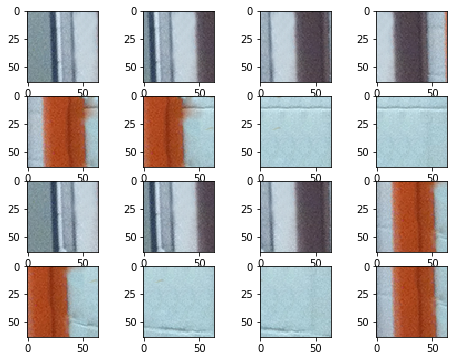

In [19]:
fig = plt.figure(figsize=(8, 6))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(samples_fake_np[i, :, :, :])

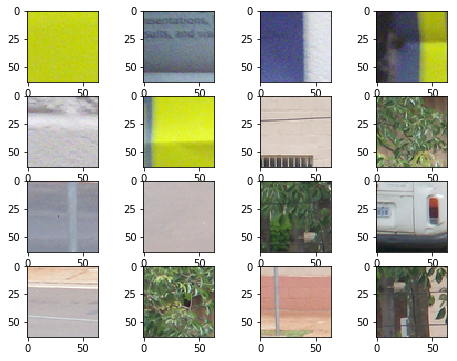

In [21]:
fig = plt.figure(figsize=(8, 6))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    ax.imshow(samples_pristine_np[i+5560, :, :, :])

In [22]:
train_data_binary = np.concatenate((samples_pristine_np, samples_fake_np), axis=0)
train_data_binary.shape

(93385, 64, 64, 3)

In [23]:
train_labels=[0]*len(samples_pristine_np)+[1]*len(samples_fake_np)

train_labels_binary = np.array(train_labels).reshape(-1, 1)

train_labels_binary.shape

(93385, 1)

In [24]:
from sklearn.model_selection import train_test_split

x_train, x_cv, y_train, y_cv = train_test_split(train_data_binary, train_labels_binary, test_size=0.2, stratify = train_labels_binary)

In [85]:

import keras
from keras.models import load_model, Sequential
from keras.layers import Dense, Flatten
from keras.applications.resnet50 import ResNet50


In [59]:
vgg_model=keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

model_aug=Sequential()
model_aug.add(vgg_model)

top_model=Sequential()
top_model.add(Flatten(input_shape=(2, 2, 512)))
#model_aug.add(Dropout(0.3))
top_model.add(Dense(64, activation='relu'))

top_model.add(Dense(1, activation='sigmoid'))

model_aug.add(top_model)

for layer in model_aug.layers[0].layers[:17]:
    layer.trainable=False

model_aug.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-6), metrics=['accuracy'])

In [60]:
#model_aug.load_weights(resume_weights)

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1)]



In [67]:
history = model_aug.fit(x_train, y_train, batch_size = 2, epochs = 100, verbose = 1, validation_data=(x_cv, y_cv), callbacks=callbacks) #)

Train on 74708 samples, validate on 18677 samples
Epoch 1/100


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node vgg16_3/block1_conv1/convolution (defined at /home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:3332)  = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](vgg16_3/block1_conv1/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, block1_conv1_3/kernel/read)]]
	 [[{{node metrics_3/acc/Mean_1/_967}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_723_metrics_3/acc/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'vgg16_3/block1_conv1/convolution', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tornado/gen.py", line 781, in inner
    self.run()
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tornado/gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-59-3f5ee418a68f>", line 4, in <module>
    model_aug.add(vgg_model)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/keras/models.py", line 467, in add
    layer(x)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/keras/engine/topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/keras/engine/topology.py", line 2078, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/keras/engine/topology.py", line 2229, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/keras/layers/convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3332, in conv2d
    data_format=tf_data_format)
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 780, in convolution
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 868, in __call__
    dilation_rate=dilations,
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 520, in __call__
    raise ValueError("filter_shape must be specified for SAME padding")
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 204, in __call__
    filter=filter,
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 957, in conv2d
    1-D tensor of length 4.  The stride of the sliding window for each
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    input_types=input_types, attrs=attr_protos,
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    if is_kwargs_deprecated and kwargs:
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    if not isinstance(a, Tensor):
  File "/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    if input_types is None:

UnknownError (see above for traceback): Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node vgg16_3/block1_conv1/convolution (defined at /home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:3332)  = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](vgg16_3/block1_conv1/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, block1_conv1_3/kernel/read)]]
	 [[{{node metrics_3/acc/Mean_1/_967}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_723_metrics_3/acc/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [64]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()

device_name

'/device:GPU:0'

In [69]:
np.save('x_train.npy', x_train)
np.save('x_cv.npy', x_cv)
np.save('y_train.npy', y_train)
np.save('y_cv.npy', y_cv)

In [75]:
x_train.shape, x_cv.shape, y_train.shape, y_cv.shape

((74708, 64, 64, 3), (18677, 64, 64, 3), (74708, 1), (18677, 1))

In [73]:
import pickle 

with open('x_test_fake_mask.pickle', 'wb') as f:
    pickle.dump(x_test_fake_mask, f)
    
with open('x_test_fake.pickle', 'wb') as f:
    pickle.dump(x_test_fake, f)

In [79]:
test =np.load('x_train.npy')
test.shape

(74708, 64, 64, 3)

In [83]:
with open('x_test_fake_mask.pickle', 'rb') as f:
    test2 =pickle.load(f)

In [84]:
len(test2)

10